In [22]:
import rich
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from itertools import cycle
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics  import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MultiLabelBinarizer
# from cbm_joint_sparse_obert import MyDataset

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Normalization on/off
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = "Confusion matrix without normalization"

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.tight_layout()

def plot_roc_curve(num_classes, y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Plot')
    plt.legend(loc="lower right")
    plt.show()

# the same evaluate_model used in BERTweet_train.py
# def evaluate_model(model, device, val_loader):
#     model.eval()
#     total, correct = 0, 0
#     all_preds, all_labels = [], []

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)

#             preds = model(input_ids, attention_mask, return_logits=False)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#             # Calculate accuracy
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     accuracy = correct / total
#     f1 = f1_score(all_labels, all_preds, average='macro') # balanced
#     # f1 = f1_score(all_labels, all_preds, average='macro') # unbalance
    
    # return accuracy, f1


In [3]:
class BertweetClassifier(nn.Module):
    def __init__(self, bertweet_model, num_labels):
        super(BertweetClassifier, self).__init__()
        self.bertweet = bertweet_model
        torch.manual_seed(seed=42)
        self.classifier = nn.Linear(self.bertweet.config.hidden_size, 
                                    num_labels)
        
    def forward(self, input_ids, attention_mask=None, return_logits=True):
        outputs = self.bertweet(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        if return_logits: # Use for training with cross-entropy loss
            return logits  
        else:
            predictions = torch.argmax(logits, dim=1) + 1  # +1 to adjust class range to 1-5
            return predictions

class TwitterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True,
        )
        
        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rich.print(f"Device: [red]{device}")
# bertweet  = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
model = torch.load('/Users/xyc/Desktop/thesis/model/retrained_BERTweet_balanced_acc_0.55.pth', map_location=torch.device('cpu'))
model.to(device)

Device: cpu

BertweetClassifier(
  (bertweet): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [5]:
# Load the datasets
df_train = pd.read_csv("/Users/xyc/Desktop/thesis/data/twitter-2016train-CE.tsv", sep='\t', header=None, quoting=3)
df_test  = pd.read_csv("/Users/xyc/Desktop/thesis/data/twitter-2016test-CE.tsv", sep='\t', header=None, quoting=3)
df_tweet = pd.concat([df_train, df_test], ignore_index=True)
df_tweet['converted_score'] = df_tweet[2] + 3

# Determine the smallest class size
class_counts = df_tweet['converted_score'].value_counts()
smallest_class_size = class_counts.min()

# Resample each class to have the same number of instances
final_sample = pd.DataFrame() 

for class_value in class_counts.index:
    df_class = df_tweet[df_tweet['converted_score'] == class_value]
    df_class_sampled = df_class.sample(n=smallest_class_size, random_state=42, replace=False)
    final_sample = pd.concat([final_sample, df_class_sampled], axis=0)

# Reset the index of the final sample dataframe
final_sample.reset_index(drop=True, inplace=True)
_, df_test = train_test_split(final_sample, test_size=0.2, random_state=42)

test_dataset = TwitterDataset(
    texts=df_test[3].values,
    labels=df_test['converted_score'].values,
    tokenizer=tokenizer,
    max_len=130
)

test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Confusion matrix

In [11]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs  = nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1) +1

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

labels, preds, y_score = evaluate_model(model, test_loader, device)


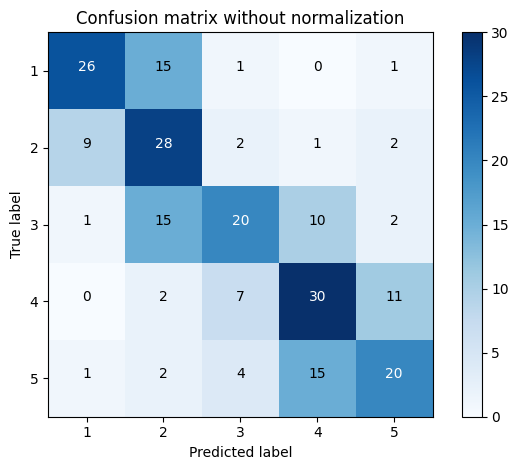

In [17]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, classes=[str(i+1) for i in range(5)])

## ROC

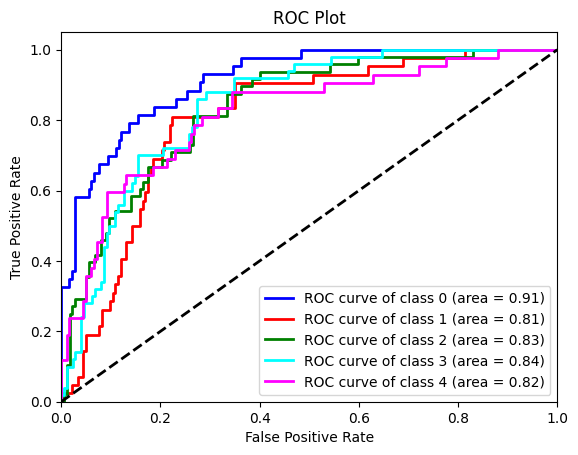

In [24]:
y_test = label_binarize(labels, classes=[1, 2, 3, 4, 5])
plot_roc_curve(5, y_test, y_score)
